In this notebook, we show how to compute the charge current (Fig. 4), and how to obtain the average number of particles (similar to Fig. 12 (a)) and average charge in the center dots (similar to Fig. 3(c)).

In [1]:
%load_ext autoreload
%autoreload 1
%aimport resources

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, hbar, k
import qutip as qt

from resources import Hamiltonian1DVirtual, Simulation, solve_resonance, register_colormap, compute_map

k_b = k / e * 10 ** 6  # Boltzmann constant [ueV / K]

cmap = plt.get_cmap('gist_heat_r')

In [3]:
N = 4
n_particles = [0, 1]

tau = [3, 5, 2]
U = np.array([1500, 1650, 1220, 1800])  # ueV
V1 = 1000
Vs = np.array([0, V1, V1 / 2, V1 / 3])

alpha = np.zeros((N, N))  # ueV / mV
alpha[:, 0] = [-85, -36, -12, -7]
alpha[:, 3] = [-7, -12, -32, -81]

V_i = [0, 0, 0, 0]  # V
eps_0 = np.array([0., 7, -5, 0.])  # ueV

T = 0.1  # K
beta = 1 / (k_b * T) if T != 0 else np.inf  # ueV^-1

Deltas = np.array([0.15, 0.2, 0.1, 0.14])
T1 = 1e3  # Relaxation (ns)
T2 = 10  # Decoherence (ns)

mu0 = 0
Delta_mu = 75
mus = np.array([0.] * N)
mus[0] = mu0 + Delta_mu / 2
mus[-1] = mu0 - Delta_mu / 2

Gammas = np.array([0.] * N)
Gammas[0] = 0.28  # uev
Gammas[-1] = 0.21
gamma = Gammas[-1]

intensity_contribution = np.array([0] * N)
intensity_contribution[-1] = 1

gamma = Gammas[-1]
gamma_J = gamma * 1e-6 * e  # J
current_change = gamma_J * e / hbar * 1e12  # pA

hamiltonian = Hamiltonian1DVirtual(N=N, tau=tau, U=U, Vs=Vs, Gammas=Gammas, mus=mus, beta=beta, n_particles=n_particles,
                                   hbar=1, T2=T2, T1=T1, intensity_contribution=intensity_contribution, Deltas=Deltas,
                                   alpha=alpha, V_i=V_i, eps_0=eps_0)

simulation = Simulation(hamiltonian)

In [5]:
n_V = 100  # Increase this number for finer resolution

v_1_run = np.linspace(-1, 1, n_V) * 1
v_4_run = np.linspace(-1, 1, n_V) * 1

V_1, V_4 = [x.flatten() for x in np.meshgrid(v_1_run, v_4_run)]

n_total = len(V_1)
V_s = [[V_1[i], 0., 0., V_4[i]] for i in range(n_total)]

In [6]:
intensity, average_population, population_ss = compute_map(simulation, V_s, 'V_i',
                                                           v_1_run, v_4_run, n_workers=-1,
                                                           ss_kw={'method': 'direct', 'solver': 'spsolve'})

intensity *= current_change

compute_current_ss: [['V_i']]:   0%|          | 0/10000 [00:00<?, ?it/s]

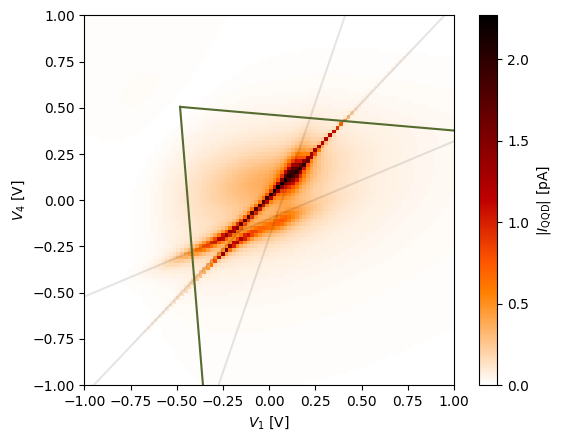

In [7]:
fig, ax = plt.subplots()

im = ax.imshow(np.abs(intensity), origin='lower', aspect='equal', vmin=0,
               extent=[min(v_1_run), max(v_1_run), min(v_4_run), max(v_4_run)], cmap=cmap)

ax.set_xlabel(r'$V_1$ [V]')
ax.set_ylabel(r'$V_4$ [V]')
cbar = plt.colorbar(im, label=r'$|I_\mathrm{QQD}|$ [pA]')

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

resonances = [['1000', '0001'], ['0100', '0001'], ['1000', '0010']]
for resonance in resonances:
    ax.plot([min(v_1_run), max(v_1_run)], solve_resonance(hamiltonian, resonance,
                                                          [min(v_1_run), max(v_1_run)]),
            color='k', alpha=0.1, ls='-')

v_1_stop = (alpha[3, 3] * mus[0] - alpha[0, 3] * mus[-1]) / (- alpha[0, 3] * alpha[3, 0] + alpha[0, 0] * alpha[3, 3])
v_1_plot = np.array([v_1_stop, np.max(v_1_run)])

ax.plot(v_1_plot, (-v_1_plot * alpha[0, 0] + mus[0]) / alpha[0, 3], color='darkolivegreen')  # (0,0,0,0) ---> (1,0,0,0)
ax.plot(v_1_plot, (-v_1_plot * alpha[3, 0] + mus[-1]) / alpha[3, 3], color='darkolivegreen')  # (0,0,0,0) ---> (0,0,0,1)

ax.set_xlim(*x_lim)
ax.set_ylim(*y_lim);

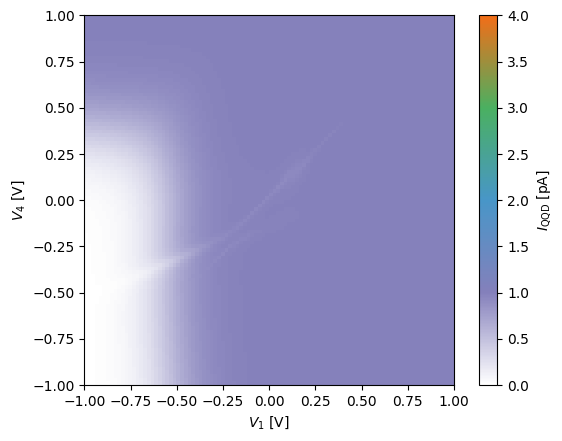

In [8]:
my_Colors = ['#FFFFFF', '#8480bb', '#4896c8', '#4ab061', '#f26e18']
register_colormap(f'my_Colors', my_Colors)

fig, ax = plt.subplots()

im = ax.imshow(average_population, origin='lower', aspect='equal', vmin=0, vmax=4,
               extent=[min(v_1_run), max(v_1_run), min(v_4_run), max(v_4_run)],
               cmap='my_Colors')

ax.set_xlabel(r'$V_1$ [V]')
ax.set_ylabel(r'$V_4$ [V]')
cbar = plt.colorbar(im, label=r'$I_\mathrm{QQD}$ [pA]')

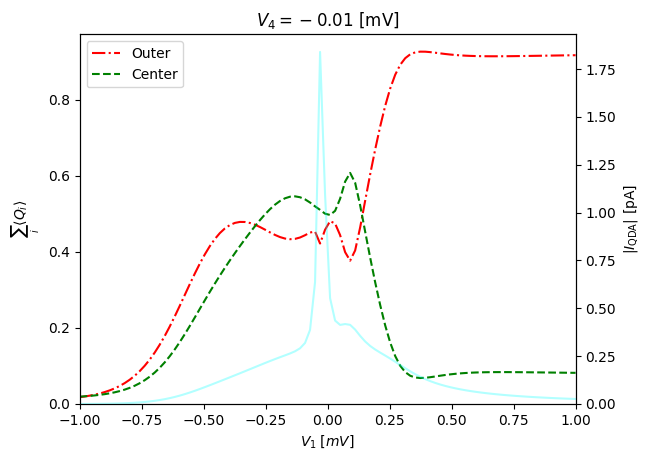

In [9]:
population_i = [simulation.population_dot(population_ss, i) for i in [0, 1, 2, 3]]

fig, ax = plt.subplots()

v4_target = 0
index = np.argmin(np.abs(v4_target - v_4_run))

ax.set_title(rf'$V_4 = {v_4_run[index]:.2f}$ [mV]')
ax.plot(v_1_run, (population_i[0] + population_i[3])[index], 'r-.', label=f'Outer')
ax.plot(v_1_run, (population_i[1] + population_i[2])[index], 'g--', label=f'Center')

ax2 = ax.twinx()
ax2.plot(v_1_run, intensity[index], '-', c='cyan', alpha=0.3)
ax2.set_ylim(0, None)
ax2.set_ylabel(r'$|I_\mathrm{QDA}|$ [pA]')

ax.set_xlabel(r'$V_1\; [mV]$')
ax.set_xlim(min(v_1_run), max(v_1_run))
ax.set_ylim(0, np.max(population_i))
ax.set_ylabel(r'$\sum_i\langle Q_i\rangle$')
ax.legend();